<a href="https://colab.research.google.com/github/BryanGonzalez262/Integral_DS/blob/main/DS_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [ ]:
%pip install sodapy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.


In [ ]:
import urllib.request, json
import pandas as pd
import seaborn as sns
import datetime
import requests
from sodapy import Socrata
import matplotlib.pyplot as plt

# Load 311 Data

In [ ]:

data_url='data.cityofnewyork.us'    # The Host Name for the API endpoint (the https:// part will be added automatically)
data_set='erm2-nwe9'    # The data set at the API endpoint (311 data in this case)
app_token='XXXXXXXXXXX'   # The app token created in the prior steps
client = Socrata(data_url,app_token)      # Create the client to point to the API endpoint
# Set the timeout to 60 seconds
client.timeout = 60
# Retrieve the first 2000 results returned as JSON object from the API
# The SoDaPy library converts this JSON object to a Python list of dictionaries
where_clause = "complaint_type = 'Rodent' AND date_extract_y(created_date)=2022"
results = client.get(data_set,
                     where=where_clause,
                     limit=200000) # limit selected after running with select="COUNT(*)" arg
# Convert the list of dictionaries to a Pandas data frame
df_311 = pd.DataFrame.from_records(results)

# Load DOHMH Data

In [ ]:
data_set='43nn-pn8j'    # The data set at the API endpoint (311 data in this case)
where_clause = "violation_code IN ('04K','04L','08A') AND date_extract_y(inspection_date)=2022"

results2 = client.get(data_set,
                      where=where_clause,
                      limit=200000)
df_DOHMH = pd.DataFrame.from_records(results2)

Community board

In DOHMHM:
1XX = Manhatttan
2XX = Bronx
3XX = Brooklyn (i.e. 303 = '03 Brooklyn')
4XX = Queens
5XX = Staten Island

In [ ]:
df_DOHMH =  df_DOHMH[df_DOHMH['community_board'].notna()]
df_DOHMH.groupby(['boro']).community_board.unique()

boro
Bronx            [205, 201, 211, 202, 206, 212, 204, 208, 210, ...
Brooklyn         [309, 318, 303, 302, 304, 305, 315, 307, 301, ...
Manhattan        [111, 107, 103, 102, 101, 104, 108, 106, 105, ...
Queens           [413, 404, 409, 401, 412, 405, 411, 402, 408, ...
Staten Island                                 [502, 501, 503, 595]
Name: community_board, dtype: object

In [ ]:
# Drop rows with unspecified community board
df_311 = df_311[~df_311.community_board.str.contains('Unspecified') ]

CB_code = {'MANHATTAN': 1, 'BRONX': 2, 'BROOKLYN': 3, 'QUEENS': 4, 'STATEN': 5}
df_311['comm_brd'] =  df_311.apply(lambda x: str(CB_code[x.community_board.split(' ')[1]])+ x.community_board.split(' ')[0], axis=1)
df_311.groupby(['borough']).comm_brd.unique()

borough
BRONX            [207, 202, 211, 210, 203, 209, 208, 201, 212, ...
BROOKLYN         [301, 308, 316, 312, 314, 304, 310, 303, 317, ...
MANHATTAN        [111, 106, 107, 108, 105, 101, 103, 112, 104, ...
QUEENS           [405, 412, 414, 408, 407, 409, 404, 402, 411, ...
STATEN ISLAND                                 [501, 503, 502, 595]
Name: comm_brd, dtype: object

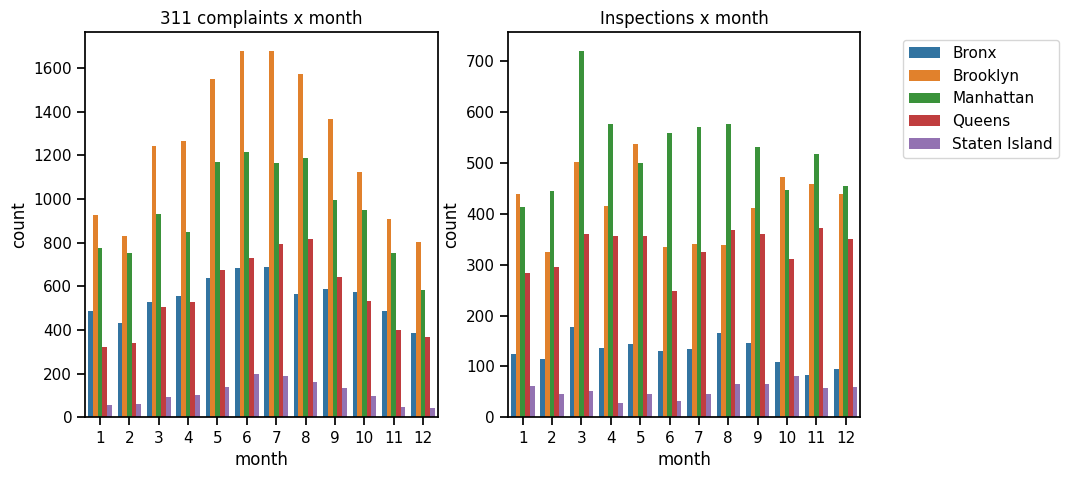

In [ ]:
sns.set_context('notebook')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

df_311['date'] = df_311.created_date.apply(pd.to_datetime)
df_311['month'] = df_311.date.dt.month
g = sns.countplot(x='month', hue = 'borough', hue_order=sorted(df_311.borough.unique()), data=df_311, ax=ax[0])
g.axes.set_title('311 complaints x month')
ax[0].legend().remove()

df_DOHMH['date'] = df_DOHMH.inspection_date.apply(pd.to_datetime)
df_DOHMH['month'] = df_DOHMH.date.dt.month
g = sns.countplot(x='month', hue = 'boro', hue_order=sorted(df_DOHMH.boro.unique()), data=df_DOHMH, ax=ax[1])
g.legend(bbox_to_anchor=(1.1, 1))
g.axes.set_title('Inspections x month');


In [ ]:
df = df_311.groupby('comm_brd').unique_key.count().reset_index()
df.rename(columns={'unique_key': 'nComplaints'}, inplace=True)

In [ ]:
xx = df_DOHMH.reset_index(names='nInspects').groupby('community_board').nInspects.count().reset_index()

df = df.merge(xx, left_on='comm_brd', right_on='community_board')

In [ ]:
df['borough'] = ''
for bor, key in CB_code.items():
    df.loc[df.community_board.astype(str).str.startswith(str(key)), 'borough'] = bor
df.head()

,comm_brd,nComplaints,community_board,nInspects,borough
0,101,207,101,367,MANHATTAN
1,102,648,102,888,MANHATTAN
2,103,842,103,900,MANHATTAN
3,104,664,104,735,MANHATTAN
4,105,238,105,1063,MANHATTAN


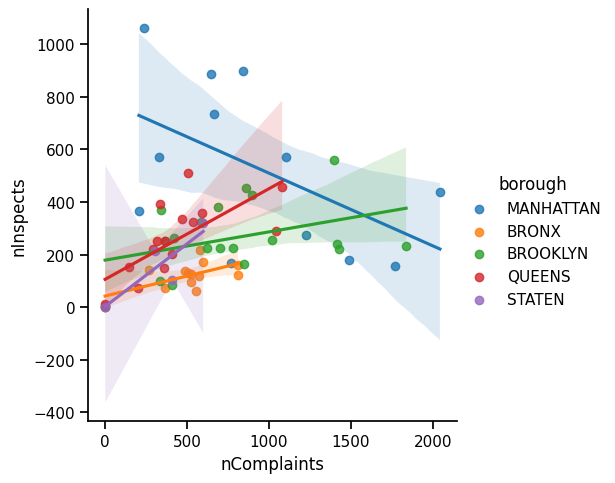

In [ ]:
g = sns.lmplot(x='nComplaints', y='nInspects', hue='borough', data=df);

## Summary
The plot above shows the number of 311 Rodent complaints X the number of DOHMH inspection violations. Each point represents a community board. In most community board districts, there is a strong relationship between 311 complaints and inspections such that districts with more complaints also recieve more inspections. In Manhattan, however, this relationship is inverse.


### given more time
I would run a mixed-effects linear model regressing the number of 311 complaints on the number of inspections with communicty board as a predictor variables and a random intercept and slope for borough. If possible, I would also normalize these values based on location type.

# 2. COVID

Rapid antigen COVID tests are approximately 80% accurate. A New Yorker takes a rapid antigen COVID test and gets a positive result for COVID infection. What is the probability they truly have COVID? Assume the base rate of COVID infection in the population is 1% and that the accuracy is the same for both positive and negative results. How accurate would the rapid antigen test need to be to increase the probability of the test-taker truly having COVID by 10%?

- A: The New Yorker has COVID.
- B: The rapid antigen test result is positive

_Bayes Theorem_
\begin{equation}
P(\textbf{A}|\textbf{B}) =  \frac{P(\textbf{B} | \textbf{A}) \times P(\textbf{A})}{P(\textbf{B})}
\end{equation}

In [ ]:
p_A = 0.01 # base rate of COVID infection in the population
p_NOTA = 1 - p_A
pB_givenA = 0.8 # probability of a true positive, which is the accuracy
pB_givenNOTA = 1 - pB_givenA # probability of false positive

# calculate P(B)
# P(B) = P(B|A) * P(A) + P(B|¬A) * P(¬A)
p_B = (pB_givenA * p_A) + (pB_givenNOTA*p_NOTA)
# compute P(A|B) : the probability a NYer truly has covid given a positive test
pA_givenB = (pB_givenA * p_A)/ p_B

## The probability of a New York truly having COVID given a positive rapid test is 3.88%

We need to find the new accuracy, denoted as x, such that:
\begin{e1}
P'(A|B) = \frac{x \times P(A) }{ x \times P(A) + (1 - x) \times P(\neg A)}
\end{e1}

Simplifying
0.0488 = (0.01x) / (0.01x + 0.99 - 0.99x)

0.0488 = 0.01x / (0.01 - 0.98x)

0.0488(0.01 - 0.98x) = 0.01x

0.000488 - 0.047824x = 0.01x

0.057312x = 0.000488

x ≈ 0.000488 / 0.057312

x ≈ 0.0085

## Therefore, the rapid antigen test would need to have an accuracy of approximately 0.0085, or 0.85%, to increase the probability of the test-taker truly having COVID by 10%.



# 3. City Tax Lots

At ODA, we collaborate with City agencies and offices to answer analytical questions, which can include questions like how to allocate scarce resources or model relationships between different variables, but also provide advice on analytical methods. You are an ODA Data Scientist, and one morning you get a call from a City agency. The Agency explains that they are using an algorithm to classify street-level images of City tax lots to try and identify the use of the lot using 3 categories: residential, business, or mixed-use. They have labeled 2,000 street-level images of tax lots as either residential, business or mixed-use to train the algorithm. They are interested in feedback on their approach.
● What would you advise the Agency about their approach?
● What are some of the considerations when using these kinds of models to classify
labeled images?
● What would you recommend as an approach to achieving their objective?

___________



### I would recommend the agency take a cross-validation approach when training, such as Leave-One-Out.  Training can be done using a fully-connected convolutional neural network (with batch normalization and cross-entropy loss function). Serious consideration must be made about the format of the training data. Variations in the training data may be due to the kind of camera used, date and time of collection, weather in the area, etc. As these factors may lead to bias. All images should be the same # of pixels, greyscaled,etc.
